In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pre
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
import re

In [2]:
raw_df = pd.read_csv("../data/train.csv")
final_test = pd.read_csv("../data/test.csv")

In [3]:
raw_df = raw_df.drop(['Name', 'Ticket'], axis=1)

In [4]:
raw_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
np.random.seed(42)
shuffled_df = raw_df.sample(frac=1).reset_index(drop=True)

dum_df = pd.get_dummies(shuffled_df, columns=['Embarked'], dtype=float)

dum_df['Sex'] = dum_df['Sex'].map({'male': 1, 'female': 0}) 

dum_df['Cabin'] = dum_df['Cabin'].isna().astype(int)

column_to_move = "Survived"
features = dum_df.drop(column_to_move, axis=1)

train_size = int(dum_df.shape[0] * 0.85)
test_size = dum_df.shape[0] - train_size

train_feats = features[:train_size]
test_feats = features[train_size:]

train_class = dum_df['Survived'][:train_size]
test_class = dum_df['Survived'][train_size:]

tree_train = shuffled_df[:train_size] 
tree_test = shuffled_df[train_size:] 

In [ ]:
def encode_names(df):
    df['Name'] = [re.search(r", ([A-Za-z ]+)\.", name).group(1) if re.search(r", ([A-Za-z ]+)\.", name) else name for name in df['Name']]
    df = pd.get_dummies(df, columns=['Name'], dtype=int)
    return df

def process_and_split(train_df, test_df):
    # Add a column to identify the original dataset
    train_df["is_train"] = 1
    test_df["is_train"] = 0

    # Combine datasets
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Encode names
    combined_df = encode_names(combined_df)

    # Split them back
    train_df = combined_df[combined_df["is_train"] == 1].drop(columns=["is_train"])
    test_df = combined_df[combined_df["is_train"] == 0].drop(columns=["is_train"])

    return train_df, test_df

In [6]:

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_feats)
scaled_test = scaler.transform(test_feats)

scaled_train_df = pd.DataFrame(scaled_train, columns=features.columns)
scaled_test_df = pd.DataFrame(scaled_test, columns=features.columns)

# Step 2: Add the "Class" column back to the DataFrame
scaled_train_df[column_to_move] = train_class.values

scaled_test_df[column_to_move] = test_class.values



In [7]:

K = 10
fold_size = len(scaled_train_df) // K
folds_X = [scaled_train_df[i*fold_size:(i+1)*fold_size] for i in range(K)]

#Variables for hyperparameter tuning
neighbors = range(3,35,2) 
distance_measures = ["manh", "euc", "cheb", "cos"]

In [8]:
def compute_masks_pre(values):
    """
    Compute masks for non-NaN values for the entire dataset.
    Returns the masks.
    """
    return ~pd.isna(values)

def make_predictions_parallel(train, test, n_neighbors, dist):
    """
    Make predictions for all test rows in parallel.
    """
    # Convert train DataFrame to NumPy arrays
    train_values = train.iloc[:, :-1].values
    train_labels = train  # Keeping labels in DataFrame for access
    train_masks = compute_masks_pre(train_values)
    
    # Convert test DataFrame to a list of rows
    test_rows = [row for _, row in test.iterrows()]
    predictions = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(pre.process_test_row, train_values, train_masks, train_labels, row, n_neighbors, dist) for row in test_rows]
        for future in futures:
            try:
                prediction = future.result()
                predictions.append(prediction)
            except Exception as exc:
                print(f"An error occurred: {exc}")
    return predictions

In [9]:

accuracy = []
distance = []
number_neighbors = [] 
#actual = X_test['Class']
max_accuracy = 0
best_n = 0
best_dist = "none"
for n in neighbors:
    for measure in distance_measures:
        k_acc_mean = []
        for k in range(K):
            fold_pred = folds_X[k]
            folds_train = pd.concat([folds_X[j] for j in range(K) if j != k], axis=0)
            actual = fold_pred['Survived']
            predictions = make_predictions_parallel(folds_train, fold_pred, n, measure)
            acc = accuracy_score(actual.tolist(), predictions)
            k_acc_mean.append(acc)
        print(measure)
        mean_acc = np.mean(k_acc_mean)
        accuracy.append(mean_acc)
        distance.append(measure)
        number_neighbors.append(n)

        if (mean_acc >= max_accuracy):
            max_accuracy = mean_acc
            best_n = n
            best_dist = measure
    print("DONE with: ", n)
    print(max_accuracy)




manh
euc
cheb
cos
DONE with:  3
0.7626666666666666
manh
euc
cheb
cos
DONE with:  5
0.78
manh
euc
cheb
cos
DONE with:  7
0.7813333333333333
manh
euc
cheb
cos
DONE with:  9
0.788
manh
euc
cheb
cos
DONE with:  11
0.788
manh
euc
cheb
cos
DONE with:  13
0.788
manh
euc
cheb
cos
DONE with:  15
0.788
manh
euc
cheb
cos
DONE with:  17
0.788
manh
euc
cheb
cos
DONE with:  19
0.7893333333333334
manh
euc
cheb
cos
DONE with:  21
0.7893333333333334
manh
euc
cheb
cos
DONE with:  23
0.7893333333333334
manh
euc
cheb
cos
DONE with:  25
0.792
manh
euc
cheb
cos
DONE with:  27
0.792
manh
euc
cheb
cos
DONE with:  29
0.792
manh
euc
cheb
cos
DONE with:  31
0.7933333333333333
manh
euc
cheb
cos
DONE with:  33
0.7933333333333333


In [12]:
max_accuracy

0.7933333333333333

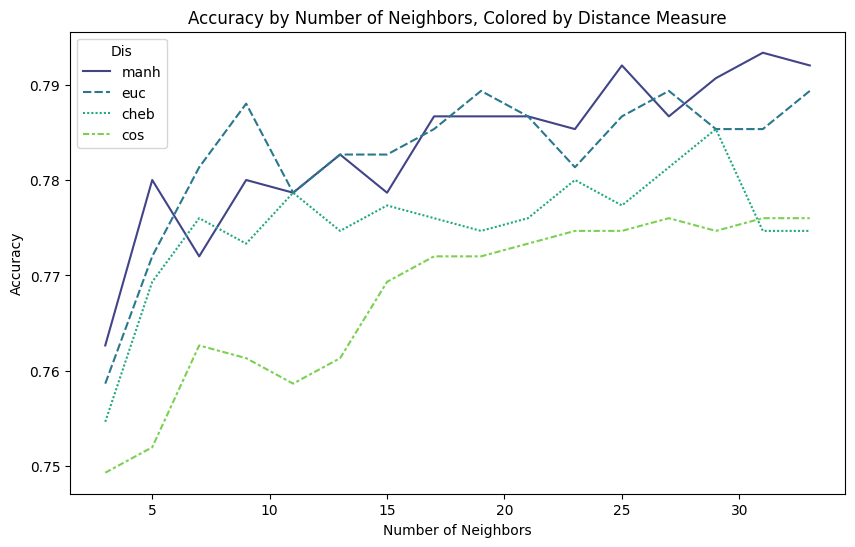

In [11]:

res = pd.DataFrame({"Acc" : accuracy, "Neig" : number_neighbors, "Dis" : distance})
res
plt.figure(figsize=(10, 6))
sns.lineplot(data=res, x='Neig', y='Acc', hue='Dis', palette='viridis', style='Dis')

# Add labels and title
plt.title('Accuracy by Number of Neighbors, Colored by Distance Measure')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

# Show plot
plt.show()